In [1]:
import torch
from torch.autograd import Variable

In [2]:
import glob

all_filenames = glob.glob('./data/names/*.txt')
print(all_filenames)

['./data/names/Korean.txt', './data/names/Portuguese.txt', './data/names/Vietnamese.txt', './data/names/Greek.txt', './data/names/Spanish.txt', './data/names/Polish.txt', './data/names/Russian.txt', './data/names/Scottish.txt', './data/names/German.txt', './data/names/Irish.txt', './data/names/Japanese.txt', './data/names/English.txt', './data/names/Chinese.txt', './data/names/Italian.txt', './data/names/French.txt', './data/names/Czech.txt', './data/names/Arabic.txt', './data/names/Dutch.txt']


In [3]:
import string
import unicodedata

all_letters = string.ascii_letters + ' .,;'
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)                  # 1. unicodedata.normalize
        if unicodedata.category(c) != 'Mn' and c in all_letters # 2. if A and B  3. then return c
    )
# 'Mn' : nonspacing mark
# NFD : https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d
# TO UNDERSTAND unicode_to_ascii : https://stackoverrun.com/ko/q/12246165

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [4]:
category_lines.keys()

dict_keys(['Korean', 'Portuguese', 'Vietnamese', 'Greek', 'Spanish', 'Polish', 'Russian', 'Scottish', 'German', 'Irish', 'Japanese', 'English', 'Chinese', 'Italian', 'French', 'Czech', 'Arabic', 'Dutch'])

In [5]:
import random

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return line, category, line_tensor, category_tensor

In [6]:
# To represent a single letter, we use a "one-hot vector" of size <1 x n_letters>.
# To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.
# That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.
print(line_to_tensor('Jones'))
print(line_to_tensor('Jones').size())

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

--------------

In [7]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initiate nn.Linear modules
        """
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_hidden = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.input_output = torch.nn.Linear(input_size + hidden_size, output_size)
        
        self.logsoftmax = torch.nn.LogSoftmax()  # log(softmax( input ))
        
    def forward(self, x, hidden):
        """
        Get your Varible and return prediction
        """
        inandhidden = torch.cat((x, hidden), 1)
        hidden = self.input_hidden(inandhidden)
        output = self.input_output(inandhidden)
        prediction = self.logsoftmax(output)
        
        return prediction, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [49]:
# confusion matrix indicating for every actual language (rows) which language the network guesses (columns)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 100000

def category_from_output(prediction):
    """
    prediction : the last output layer of our model(char-RNN)
    """
    top_tensor, top_index = prediction.data.topk(1)
    # output.data.topk returns 2 : (tensor([[-0.9770]]), tensor([[12]])) ...example
    prediction_index = top_index.squeeze()
    # torch.sqeeze : Returns a tensor with all the dimensions of input of size 1 removed.
    prediction_category = all_categories[prediction_index]
    
    return prediction_category, prediction_index

In [8]:
n_letters = 57
n_hidden = 128
n_categories = len(all_categories)

input_size, hidden_size, output_size = n_letters, n_hidden, n_categories

learning_rate = 0.005  # 1e-6 is too small here with nn
n_epoch=30000

In [50]:
model  = RNN(input_size, hidden_size, output_size)
loss_fn = torch.nn.NLLLoss()  # the negative log likelihood loss (useful to train a classification problem with C classes)
# negative loglikelihood loss vs cross entropy loss ?
# http://www.godeep.ml/cross-entropy-likelihood-relation/
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

all_losses = []
current_loss=0

for epoch in range(1, n_epoch+1):
    # data
    line, category, line_tensor, category_tensor = random_training_pair()
    
    # initialize
    model.zero_grad()  # same as 'weights.grad.data.zero_()', optimizer.zero_grad()
    hidden = model.init_hidden()
    
    # forward
    for i in range(line_tensor.size()[0]):  # n_letter for that line
        prediction, hidden = model(line_tensor[i], hidden)
    
    # confusion matrix
    prediction_category, prediction_index = category_from_output(prediction)
    confusion[category_tensor.squeeze()][prediction_index] += 1
    
    # loss
    loss = loss_fn(prediction, category_tensor)
    
    # backward
    loss.backward()
    optimizer.step() # performs a parameter update based on the current gradient
    
    current_loss += loss
    
    if epoch % 1000 == 0 :
        all_losses.append(current_loss/1000)
        print('(%d epoch) line = %s, category = %s, loss = %f' %(epoch, line, category, current_loss/1000))
        current_loss = 0

/home/hansol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(1000 epoch) line = Tanzi, category = Italian, loss = 2.864056
(2000 epoch) line = Remenny, category = Russian, loss = 2.822576
(3000 epoch) line = Klerx, category = Dutch, loss = 2.770561
(4000 epoch) line = Niall, category = Irish, loss = 2.719918
(5000 epoch) line = Vargas, category = Portuguese, loss = 2.596963
(6000 epoch) line = Mata, category = Portuguese, loss = 2.527450
(7000 epoch) line = Takudo, category = Japanese, loss = 2.394449
(8000 epoch) line = Robert, category = French, loss = 2.331736
(9000 epoch) line = Hao, category = Chinese, loss = 2.216301
(10000 epoch) line = Zambrano, category = Spanish, loss = 2.210398
(11000 epoch) line = Hadjiyianakies, category = Greek, loss = 2.188550
(12000 epoch) line = Faucheux, category = French, loss = 2.086071
(13000 epoch) line = Burns, category = Scottish, loss = 2.070467
(14000 epoch) line = Veltman, category = Russian, loss = 2.019908
(15000 epoch) line = Nobunaga, category = Japanese, loss = 2.012945
(16000 epoch) line = Kouri

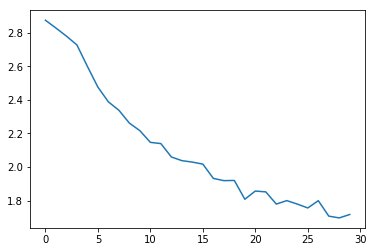

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure()
plt.plot(all_losses)

----------------

In [62]:
# normalize confusion matrix
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

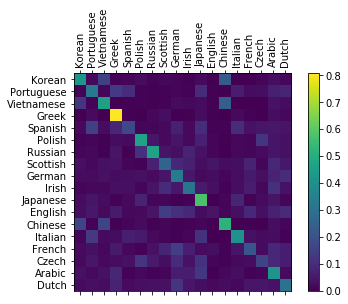

In [66]:
import matplotlib.ticker as ticker

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [101]:
def evaluate(line_tensor):
    hidden = model.init_hidden()
    
    # forward
    for i in range(line_tensor.size()[0]):  # n_letter for that line
        prediction, hidden = model(line_tensor[i], hidden)
        
    return prediction

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    prediction = evaluate((line_to_tensor(input_line)))
    top_tensor, top_index = prediction.data.topk(3)
    
    for i in range(n_predictions):
        print('(%.2f) %s' % (top_tensor.squeeze()[i], all_categories[top_index.squeeze()[i]]))


In [104]:
predict('Jack')
predict('hansol')
predict('ahaha')


> Jack
(-2.01) Korean
(-2.15) Polish
(-2.20) Vietnamese

> hansol
(-1.81) Arabic
(-1.91) Scottish
(-1.96) Irish

> ahaha
(-0.38) Japanese
(-2.28) Arabic
(-2.39) Irish


/home/hansol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
